In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

In [60]:
max_words = 3000
max_len = 30
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')

In [5]:
train = shuffle(train)

In [6]:
count_row = train.shape[0]
train_size = int(count_row * 0.75)
train_size

23971

In [7]:
df_train, df_val = train.iloc[:train_size,:], train.iloc[train_size:,:]

In [8]:
df_train.shape, df_val.shape

((23971, 3), (7991, 3))

In [10]:
df_train.head()

,id,label,tweet
17493,17494,0,make custom soundtrack for your #promotional #...
29002,29003,1,@user #prank #dad #home #slapcam #black #wait...
27386,27387,0,werk put inðð¾ð¨staed with a 3mi run an...
11138,11139,0,gonna be doing new content soon
653,654,0,how utterly : people with incurable #stupidi...


0 - negative<br>
1 - positive

In [11]:
df_train['label'].value_counts()

0    22263
1     1708
Name: label, dtype: int64

In [12]:
def balance_df(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [13]:
df_train = balance_df(df_train, 'label')

In [14]:
df_val.tail()

,id,label,tweet
21203,21204,0,"need a hug, nececito un abrazo. ð #overwhel..."
12715,12716,0,destination wedding aruba @user arubaweddings...
3290,3291,0,@user just bought the wiley fox storm and will...
27352,27353,0,choose happiness. #personaldevelopment #home...
23707,23708,0,watched @user @user and #tonyawards to catch a...


In [15]:
df_val['label'].value_counts()

0    7457
1     534
Name: label, dtype: int64

### Предобработка

In [16]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 8.2 MB 26.1 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=34038957858f9c10a4ac6a44cdbcd2c73c7fbc7b48de75ffea5a93174d46ff0a
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [25]:
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [18]:
sw = stopwords.words('english')
# sw

In [19]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [26]:
wnl = WordNetLemmatizer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("[â|ð|u|ððð|ðð]", "", txt)
    txt = [wnl.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [27]:
df_train['tweet'].iloc[:2].values

array(['about time i staed packing travelling amsterdam twodays   ',
       'trump ny cochair i want obama to die of mad cow disease and michelle to go back to being a male   trump'],
      dtype=object)

In [28]:
df_train['tweet'] = df_train['tweet'].str.replace (r"""[^\w\s]+""","", regex = True)

In [29]:
df_train['tweet']

4843     about time i staed packing travelling amsterda...
41515    trump ny cochair i want obama to die of mad co...
12385    brent a nude makes for a very happy christmas ...
36377    people arent protesting trump because a republ...
38858                                       a deeper look 
                               ...                        
5124     l o o k look instalook instafotoaldia instafot...
2393     its officially been 1 month and 1 day without ...
30846    obamajarretts who agenda was to destroy everyt...
40702    intolerant postbrexit britain history shows we...
16133     â wti drops to lows near 4830   blog silver g...
Name: tweet, Length: 44467, dtype: object

In [30]:
df_train['tweet'].iloc[:2].apply(preprocess_text).values

array(['abot time staed packing travelling amsterdam twodays',
       'trmp ny cochair want obama die mad cow disease michelle go back male trmp'],
      dtype=object)

In [31]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 13044.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [33]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['abot', 'time', 'staed', 'packing', 'travelling']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [34]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [35]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [36]:
tokens_filtered_top[:10]

['ser', 'yo', 'amp', 'love', 'day', 'trmp', 'like', 'yor', 'bt', 'jst']

In [37]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary[:10]

In [38]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [39]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 5.21 s, sys: 13.9 ms, total: 5.23 s
Wall time: 5.22 s


In [40]:
x_train.shape

(44467, 30)

In [41]:
df_train['tweet'].iloc[1]

'trmp ny cochair want obama die mad cow disease michelle go back male trmp'

In [42]:
x_train[1]

array([  6, 614, 533,  42,  47, 703, 497, 413, 627, 486,  37,  67, 409,
         6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, vocab_size=3000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_3 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_3 = nn.Linear(out_channel // 2, out_channel // 4)
        self.linear_2 = nn.Linear(out_channel // 4, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.dropout1(output)
        
        output = self.conv_3(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.dropout1(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.dropout1(output)
        
        output = torch.max(output, axis=2).values
        
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.dropout2(output)
        output = self.linear_3(output)
        output = self.relu(output)
        output = self.dropout2(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [62]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [63]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [64]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(0)


In [65]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [66]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(3000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_3): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)
Parameters: 509441


In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [68]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/5]. Step [87/87]. Loss: 0.149. Acc: 0.824. Test loss: 0.159. Test acc: 0.938
Epoch [2/5]. Step [87/87]. Loss: 0.117. Acc: 0.964. Test loss: 0.000. Test acc: 0.951
Epoch [3/5]. Step [87/87]. Loss: 0.062. Acc: 0.977. Test loss: 0.000. Test acc: 0.950
Epoch [4/5]. Step [87/87]. Loss: 0.059. Acc: 0.984. Test loss: 0.001. Test acc: 0.942
Epoch [5/5]. Step [87/87]. Loss: 0.061. Acc: 0.986. Test loss: 0.000. Test acc: 0.951
Training is finished!


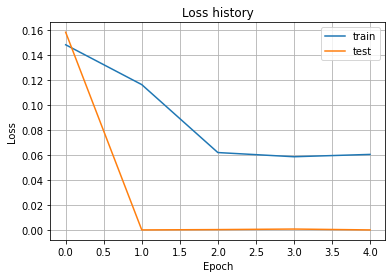

In [69]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

**Точность модели сильно улучшить не получилось, но удалось снизить потери на трейне и тесте, а также снизить переобучение при добавлении в модель следующего:**

**- добавление одного сверточного и одного плотного слоя,**

**- обнуление случайных элементов,**

**- предварительная очистка данных,**

**- балансировка классов.**

## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://drive.google.com/file/d/1S0hslcWDrwxA5GH4U32mfg85lAVLqkq5/view?usp=sharing